<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

### 1 - Datos
Utilizaremos como dataset el libro Papeles en el viento de Eduardo Sacheri. Por limitaciones de memoria de Google Colab, tuvimos que recortar el libro.

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CEIA/NLP/Desafio4/Papeles_en_el_viento.txt', sep ='/n', header=None)
df.head()

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,0
0,Cuando salen del cementerio se detienen un bue...
1,"necesitasen orientarse, o decidir qué hacer de..."
2,vistazo a los otros dos. Mauricio baja la mira...
3,los ojos se le anegan de lágrimas.
4,Es esto. La muerte del Mono es esto que está s...


### 2 - Preprocesamiento
Debemos realizar los mismos pasos que en el ejemplo anterior, pero antes de eso debemos transformar ese dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [4]:
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_teokenize de nltk
from keras.utils import pad_sequences # se utilizará para padding

# largo de la secuencia, incluye seq input + word output
train_len = 4

In [5]:
# Concatenamos todos los rows en un solo valor
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus

'Cuando salen del cementerio se detienen un buen rato en la vereda, como si necesitasen orientarse, o decidir qué hacer de allí en adelante. Fernando echa un vistazo a los otros dos. Mauricio baja la mirada. El Ruso, en cambio, se la sostiene, y los ojos se le anegan de lágrimas. Es esto. La muerte del Mono es esto que está sucediendo. Se parece a las imágenes que Fernando ha construido en ocho meses de insomnio. Se parece pero no es. La realidad es más simple, más básica. Es esto. Este sol de invierno escondiéndose del lado de Castelar, el paredón alto del cementerio, la vereda larga hasta la avenida, los camiones, ellos tres ahí, sin decidirse a nada. El Ruso alza el mentón, hacia el lado de Yrigoyen. —¿Se toman un café? Mauricio asiente y los dos empiezan a caminar hacia la esquina. Fernando demora en seguirlos. No tiene ganas de tomar un café. Pero tampoco tiene ganas de quedarse ahí parado o de volver a entrar en el cementerio. No tiene ganas de nada. Empieza a caminar con las man

In [6]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:30]

['cuando',
 'salen',
 'del',
 'cementerio',
 'se',
 'detienen',
 'un',
 'buen',
 'rato',
 'en',
 'la',
 'vereda',
 'como',
 'si',
 'necesitasen',
 'orientarse',
 'o',
 'decidir',
 'qué',
 'hacer',
 'de',
 'allí',
 'en',
 'adelante',
 'fernando',
 'echa',
 'un',
 'vistazo',
 'a',
 'los']

In [7]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 28230


In [8]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [9]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['cuando', 'salen', 'del', 'cementerio'],
 ['salen', 'del', 'cementerio', 'se'],
 ['del', 'cementerio', 'se', 'detienen'],
 ['cementerio', 'se', 'detienen', 'un'],
 ['se', 'detienen', 'un', 'buen'],
 ['detienen', 'un', 'buen', 'rato'],
 ['un', 'buen', 'rato', 'en'],
 ['buen', 'rato', 'en', 'la'],
 ['rato', 'en', 'la', 'vereda'],
 ['en', 'la', 'vereda', 'como'],
 ['la', 'vereda', 'como', 'si'],
 ['vereda', 'como', 'si', 'necesitasen'],
 ['como', 'si', 'necesitasen', 'orientarse'],
 ['si', 'necesitasen', 'orientarse', 'o'],
 ['necesitasen', 'orientarse', 'o', 'decidir'],
 ['orientarse', 'o', 'decidir', 'qué'],
 ['o', 'decidir', 'qué', 'hacer'],
 ['decidir', 'qué', 'hacer', 'de'],
 ['qué', 'hacer', 'de', 'allí'],
 ['hacer', 'de', 'allí', 'en']]

In [10]:
# Proceso de tokenizacion
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[34, 863, 15, 556],
 [863, 15, 556, 9],
 [15, 556, 9, 2166],
 [556, 9, 2166, 10],
 [9, 2166, 10, 358],
 [2166, 10, 358, 670],
 [10, 358, 670, 7],
 [358, 670, 7, 4],
 [670, 7, 4, 320],
 [7, 4, 320, 27],
 [4, 320, 27, 29],
 [320, 27, 29, 2167],
 [27, 29, 2167, 2168],
 [29, 2167, 2168, 33],
 [2167, 2168, 33, 865],
 [2168, 33, 865, 36],
 [33, 865, 36, 93],
 [865, 36, 93, 1],
 [36, 93, 1, 671],
 [93, 1, 671, 7]]

In [11]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 28226


### 3 - Input y target

In [12]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(28226, 3)
(28226,)


In [13]:
# Palabras del vocabulario
tok.index_word

{1: 'de',
 2: 'que',
 3: 'el',
 4: 'la',
 5: 'y',
 6: 'a',
 7: 'en',
 8: 'no',
 9: 'se',
 10: 'un',
 11: 'los',
 12: 'lo',
 13: 'con',
 14: 'fernando',
 15: 'del',
 16: 'ruso',
 17: 'su',
 18: 'por',
 19: 'es',
 20: 'para',
 21: 'una',
 22: 'le',
 23: 'pero',
 24: 'las',
 25: 'mono',
 26: 'al',
 27: 'como',
 28: 'te',
 29: 'si',
 30: 'más',
 31: 'me',
 32: 'mauricio',
 33: 'o',
 34: 'cuando',
 35: 'porque',
 36: 'qué',
 37: 'sus',
 38: 'vos',
 39: 'está',
 40: 'era',
 41: 'eso',
 42: 'ni',
 43: 'había',
 44: 'todo',
 45: 'ese',
 46: 'sin',
 47: 'dos',
 48: 'él',
 49: 'esa',
 50: '—no',
 51: 'yo',
 52: 'hasta',
 53: 'vez',
 54: 'tiene',
 55: 'siempre',
 56: 'otro',
 57: 'así',
 58: 'después',
 59: 'sí',
 60: 'bien',
 61: 'nada',
 62: 'hace',
 63: 'hacia',
 64: 'todos',
 65: 'va',
 66: 'pittilanga',
 67: 'años',
 68: 'les',
 69: '—¿y',
 70: '—el',
 71: 'ahora',
 72: 'ser',
 73: 'fue',
 74: 'otra',
 75: 'sobre',
 76: 'guita',
 77: 'estaba',
 78: 'poco',
 79: 'sé',
 80: 'parece',
 81: 'tre

In [14]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

6077

In [15]:
print(y_data_int[0:])

[ 556    9 2166 ...    2  283  864]


In [16]:
# En el caso anterior explota porque y_data_int comienza en "1" en vez de "0"
# valor minimo:
min(y_data_int)

1

In [17]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
y_data.shape

(28226, 6077)

In [18]:
#scaler = StandardScaler()
#scaler = MinMaxScaler()
#x_data = scaler.fit_transform(x_data)
#print(x_data[0])

### 4 - Entrenar el modelo

In [19]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

3

In [20]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

6077

Modelos: se ensayaron distintas configuraciones de modelos, con +/- capacidad aumentando tanto las units del layer LSTM como agregando mas layers en el modelo. Tambien probando distintos tamaños de la capa de embedding. Respecto al dropout, desde quitarlo hasta aumentar su valor y ponerlo despues de cada capa LSTM.

In [23]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=32, input_length=input_seq_len))

model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(128))) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 3, 32)             194496    
                                                                 
 bidirectional_3 (Bidirectio  (None, 3, 256)           164864    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 3, 256)            0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 3, 256)           394240    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 3, 256)            0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 256)             

In [24]:
hist = model.fit(x_data, y_data, epochs=50, validation_split=0.2)

Epoch 1/50
706/706 [==============================] - 27s 27ms/step - loss: 6.9784 - accuracy: 0.0433 - val_loss: 6.7538 - val_accuracy: 0.0544
Epoch 2/50
706/706 [==============================] - 15s 22ms/step - loss: 6.4032 - accuracy: 0.0492 - val_loss: 6.8682 - val_accuracy: 0.0542
Epoch 3/50
706/706 [==============================] - 14s 20ms/step - loss: 6.1598 - accuracy: 0.0571 - val_loss: 7.0710 - val_accuracy: 0.0501
Epoch 4/50
706/706 [==============================] - 18s 26ms/step - loss: 5.9624 - accuracy: 0.0686 - val_loss: 7.3024 - val_accuracy: 0.0654
Epoch 5/50
706/706 [==============================] - 15s 21ms/step - loss: 5.7766 - accuracy: 0.0755 - val_loss: 7.4929 - val_accuracy: 0.0600
Epoch 6/50
706/706 [==============================] - 19s 27ms/step - loss: 5.6085 - accuracy: 0.0834 - val_loss: 7.7538 - val_accuracy: 0.0609
Epoch 7/50
706/706 [==============================] - 18s 25ms/step - loss: 5.4469 - accuracy: 0.0895 - val_loss: 8.0086 - val_accuracy:

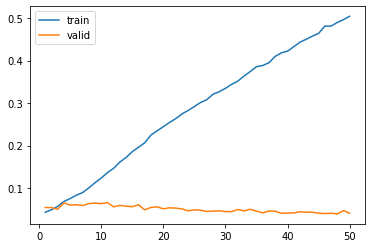

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

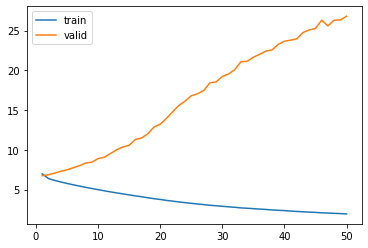

In [26]:
epoch_count = range(1, len(hist.history['loss']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['loss'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_loss'], label='valid')
plt.show()

### 5 - Predicción de próxima palabra

In [ ]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [27]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
import sys
!{sys.executable} -m pip install gradio --quiet

     |████████████████████████████████| 11.6 MB 15.4 MB/s 
     |████████████████████████████████| 84 kB 3.6 MB/s 
     |████████████████████████████████| 56 kB 5.8 MB/s 
     |████████████████████████████████| 84 kB 4.3 MB/s 
     |████████████████████████████████| 213 kB 73.8 MB/s 
     |████████████████████████████████| 2.3 MB 62.1 MB/s 
     |████████████████████████████████| 55 kB 4.3 MB/s 
     |████████████████████████████████| 54 kB 3.9 MB/s 
     |████████████████████████████████| 106 kB 75.2 MB/s 
     |████████████████████████████████| 278 kB 67.1 MB/s 
     |████████████████████████████████| 64 kB 3.0 MB/s 
     |████████████████████████████████| 80 kB 11.3 MB/s 
     |████████████████████████████████| 68 kB 8.3 MB/s 
     |████████████████████████████████| 68 kB 8.2 MB/s 
     |████████████████████████████████| 68 kB 7.9 MB/s 
     |████████████████████████████████| 46 kB 4.9 MB/s 
     |████████████████████████████████| 593 kB 68.0 MB/s 
     |████████████████████████████

In [28]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    
    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: `layout` parameter is deprecated, and it has no effect
  warnings.warn(value)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

1/1 [==============================] - 2s 2s/step
Keyboard interruption in main thread... closing server.


### 6 - Generación de secuencias nuevas

In [29]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [31]:
input_text='cuando salen del'

generate_seq(model, tok, input_text, max_length=3, n_words=2)

1/1 [==============================] - 1s 638ms/step


'cuando salen del vallejo parece'

### 7 - Conclusiones
En todos los modelos ensayados, no fue posible mejorar la performance en valid, siempre los modelos hicieron overfitting sobre los datos de train siendo casi constante la performance en valid. 

Sí, los distintos modelos afectaron la performance en train, siempre que aumentamos la capacidad de los mismo (teniendo mas parametros entrenables) la performance aumento para la misma cantidad de epoch. En este ultimo modelo entrenado, dejando correr por mas epoch, seguramente en train hubiesemos obtenidos valores razonables de performance.

Este comportamiento se debe a la poca cantidad de datos con los que fueron entrenados los modelos, no siendo posible hacerlo con un dataset mayor por la limitante en los recursos computacioneles disponibles en colab.